## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, make_scorer, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_classification
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

import time
import lightgbm as lgb
from catboost import CatBoostClassifier

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

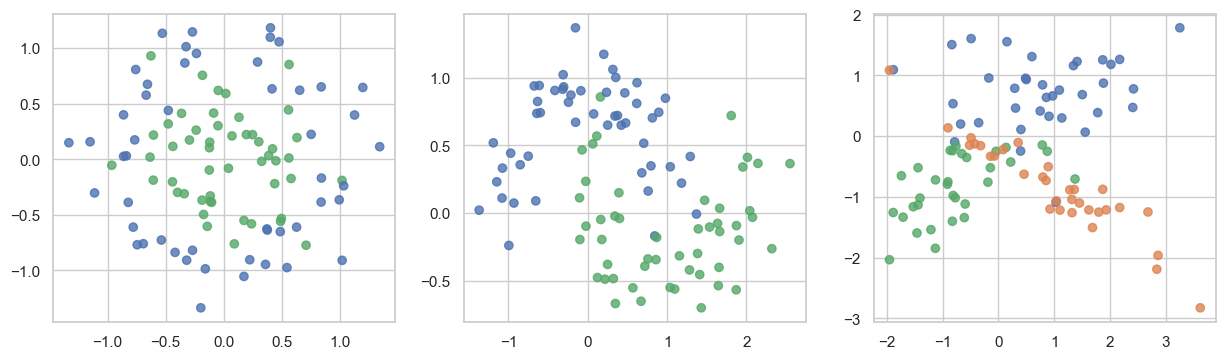

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y, ax=None, debug=False):
    
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                    edgecolors=np.array(palette)[y], linewidths=2)
    else:
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                    edgecolors=np.array(palette)[y], linewidths=2)

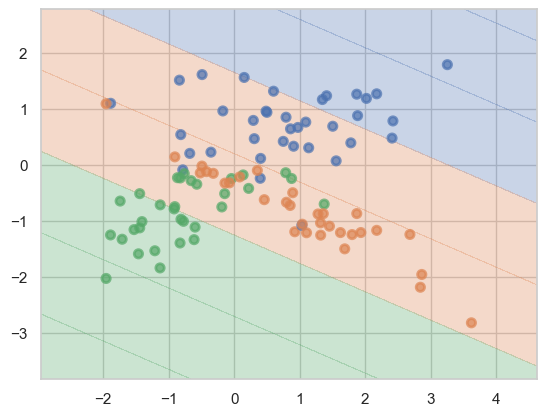

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)


--- Результаты ---
Точность на обучающей выборке: 1.0000 (100.00%)
Точность на тестовой выборке:  0.6500 (65.00%)
Разница (переобучение):        0.3500 (35.00%)


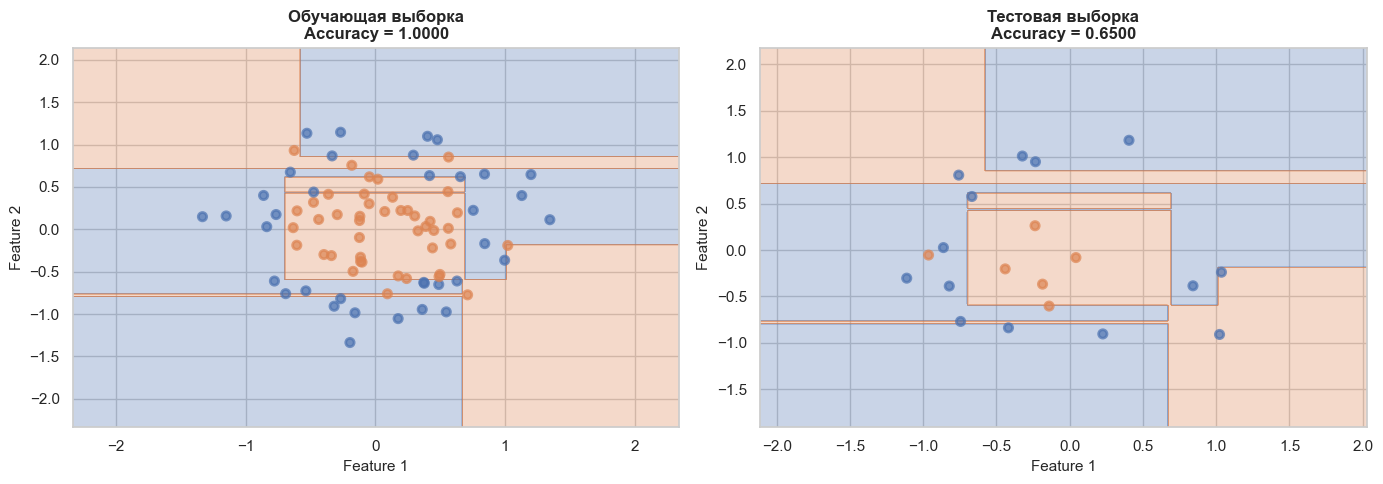


--- Результаты ---
Точность на обучающей выборке: 1.0000 (100.00%)
Точность на тестовой выборке:  0.9500 (95.00%)
Разница (переобучение):        0.0500 (5.00%)


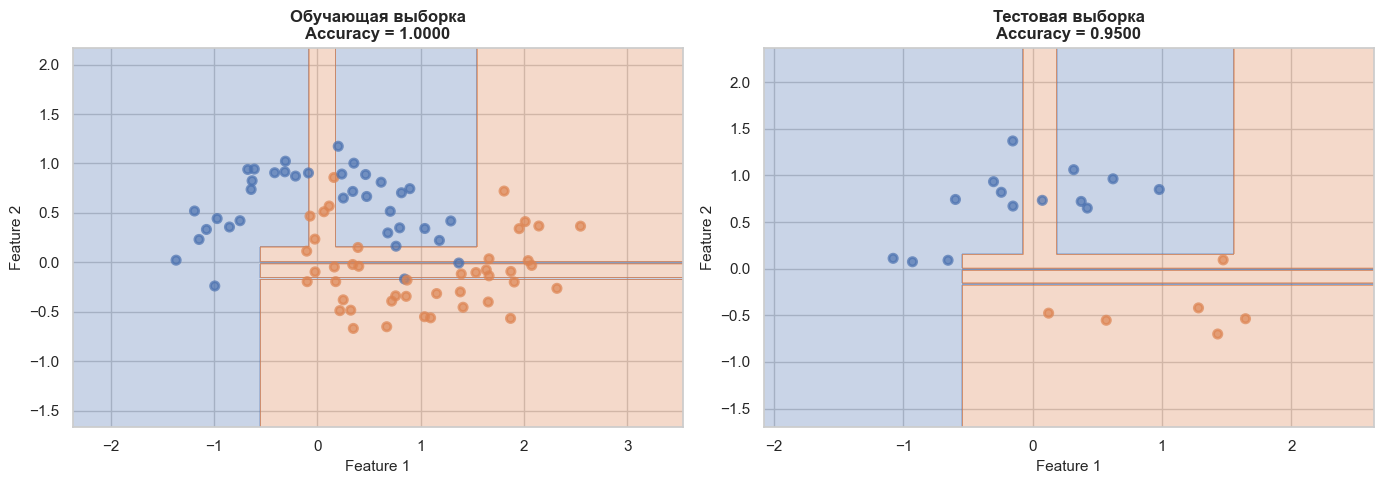


--- Результаты ---
Точность на обучающей выборке: 1.0000 (100.00%)
Точность на тестовой выборке:  0.7000 (70.00%)
Разница (переобучение):        0.3000 (30.00%)


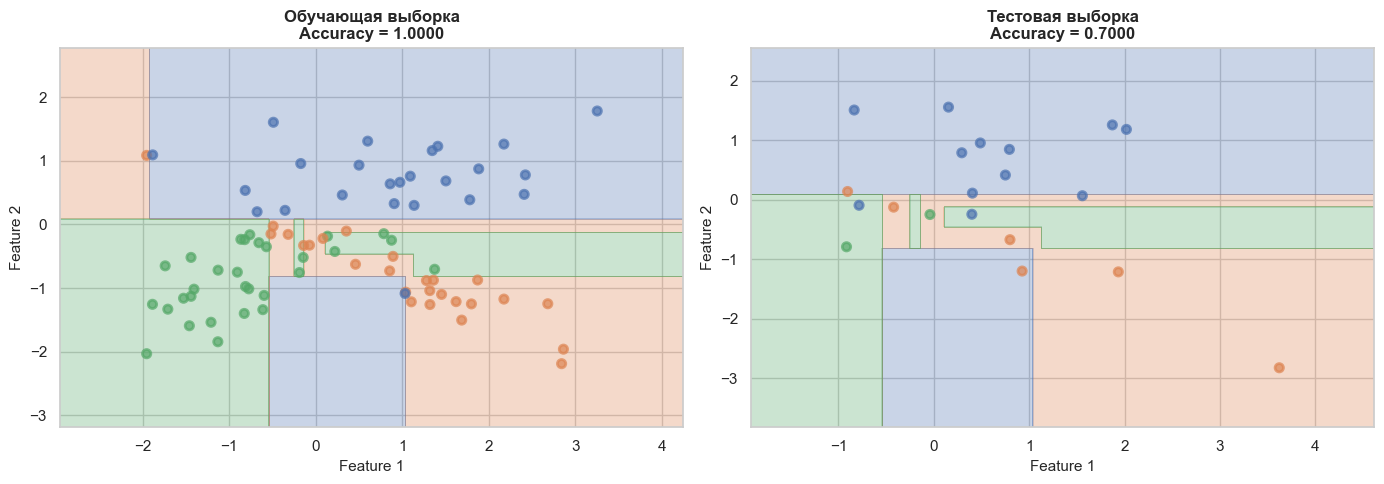

In [7]:
results = []

for idx, (X, y) in enumerate(datasets):
    # Разбиваем выборку на обучающую и тестовую (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Обучаем дерево с параметрами по умолчанию
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)
    
    # Вычисляем точность на обучающей и тестовой выборках
    train_accuracy = tree.score(X_train, y_train)
    test_accuracy = tree.score(X_test, y_test)
    overfitting_gap = train_accuracy - test_accuracy

    print(f"\n--- Результаты ---")
    print(f"Точность на обучающей выборке: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"Точность на тестовой выборке:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Разница (переобучение):        {overfitting_gap:.4f} ({overfitting_gap*100:.2f}%)")
    
    results.append({
        'Датасет': datasets[idx],
        'Train Acc': train_accuracy,
        'Test Acc': test_accuracy,
        'Переобучение': overfitting_gap,
        'Глубина': tree.get_depth(),
        'Листья': tree.get_n_leaves()
    })
    
    # Визуализация
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    # Левый график: обучающая выборка
    plot_surface(tree, X_train, y_train, axes[0])
    axes[0].set_title(f'Обучающая выборка\nAccuracy = {train_accuracy:.4f}', 
                  fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Feature 1', fontsize=11)
    axes[0].set_ylabel('Feature 2', fontsize=11)

    # Правый график: тестовая выборка
    plot_surface(tree, X_test, y_test, axes[1])
    axes[1].set_title(f'Тестовая выборка\nAccuracy = {test_accuracy:.4f}',
                  fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Feature 1', fontsize=11)
    axes[1].set_ylabel('Feature 2', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    

Вывод: Деревья __сильно переобучились__

Причины переобучения:
1. Нет ограничения роста деревьев
2. Деревья растут до тех пор, пока не классифицируют все объекты обучающей выборки идеально (до 1)
3. Деревья "запоминают" шум в обучающих данных
4. На тестовых данных точность значительно ниже

__Ответ:__

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Тест 1: Влияние max_depth на переобучение


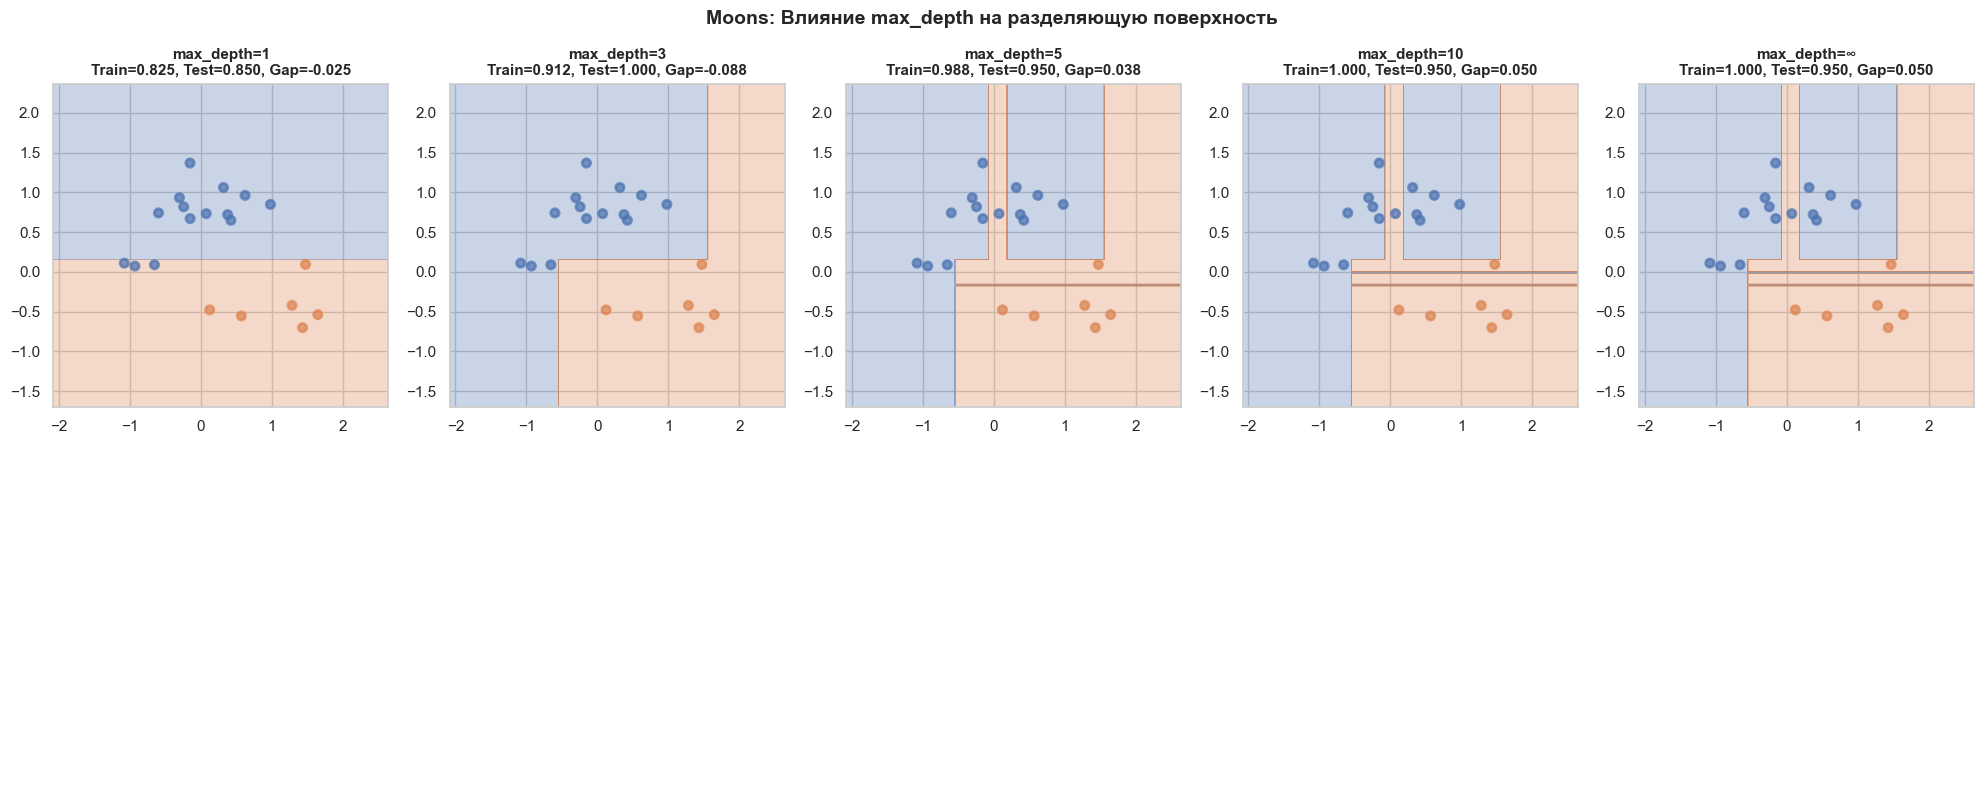


Таблица результатов (max_depth):
max_depth  Train Acc  Test Acc  Переобучение  Tree Depth  Leaves
        1     0.8250      0.85       -0.0250           1       2
        3     0.9125      1.00       -0.0875           3       6
        5     0.9875      0.95        0.0375           5       9
       10     1.0000      0.95        0.0500           6      10
        ∞     1.0000      0.95        0.0500           6      10


In [8]:
# Тест 1: max_depth

print("Тест 1: Влияние max_depth на переобучение")

# Тестируем на Moons
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depths = [1, 3, 5, 10, None]
results = []

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, depth in enumerate(max_depths):
    tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=1, random_state=42)
    tree.fit(X_train, y_train)
    
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    gap = train_acc - test_acc
    
    plot_surface(tree, X_test, y_test, axes[i])
    
    depth_str = str(depth) if depth is not None else "∞"
    axes[i].set_title(
        f'max_depth={depth_str}\nTrain={train_acc:.3f}, Test={test_acc:.3f}, Gap={gap:.3f}',
        fontsize=11, fontweight='bold'
    )
    
    results.append({
        'max_depth': depth_str,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Переобучение': gap,
        'Tree Depth': tree.get_depth(),
        'Leaves': tree.get_n_leaves()
    })

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Moons: Влияние max_depth на разделяющую поверхность', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Таблица
df = pd.DataFrame(results)
print("\nТаблица результатов (max_depth):")
print(df.to_string(index=False))


ТЕСТ 2: Влияние min_samples_leaf на переобучение


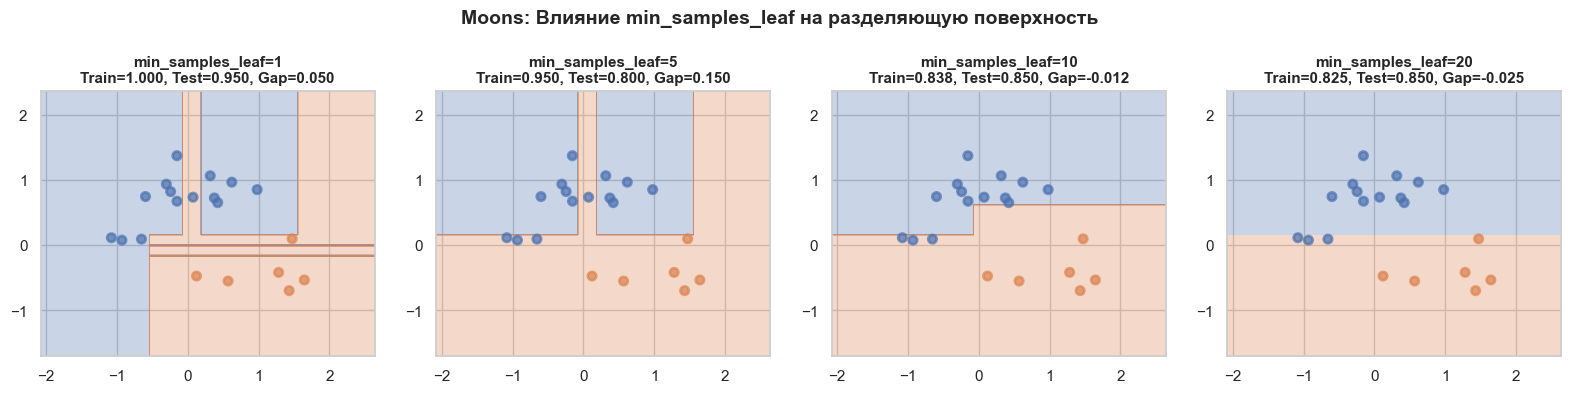


Таблица результатов (min_samples_leaf):
 min_samples_leaf  Train Acc  Test Acc  Переобучение  Tree Depth  Leaves
                1     1.0000      0.95        0.0500           6      10
                5     0.9500      0.80        0.1500           4       8
               10     0.8375      0.85       -0.0125           3       6
               20     0.8250      0.85       -0.0250           2       3


In [9]:
# Тест 2: min_samples_leaf
print("ТЕСТ 2: Влияние min_samples_leaf на переобучение")

min_samples_leafs = [1, 5, 10, 20]
results_leaf = []

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, leaf in enumerate(min_samples_leafs):
    tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=leaf, random_state=42)
    tree.fit(X_train, y_train)
    
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    gap = train_acc - test_acc
    
    plot_surface(tree, X_test, y_test, axes[i])
    axes[i].set_title(
        f'min_samples_leaf={leaf}\nTrain={train_acc:.3f}, Test={test_acc:.3f}, Gap={gap:.3f}',
        fontsize=11, fontweight='bold'
    )
    
    results_leaf.append({
        'min_samples_leaf': leaf,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Переобучение': gap,
        'Tree Depth': tree.get_depth(),
        'Leaves': tree.get_n_leaves()
    })

plt.suptitle('Moons: Влияние min_samples_leaf на разделяющую поверхность', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

df_leaf = pd.DataFrame(results_leaf)
print("\nТаблица результатов (min_samples_leaf):")
print(df_leaf.to_string(index=False))


Тест 3: Сравнение влияния max_depth для всех датасетов


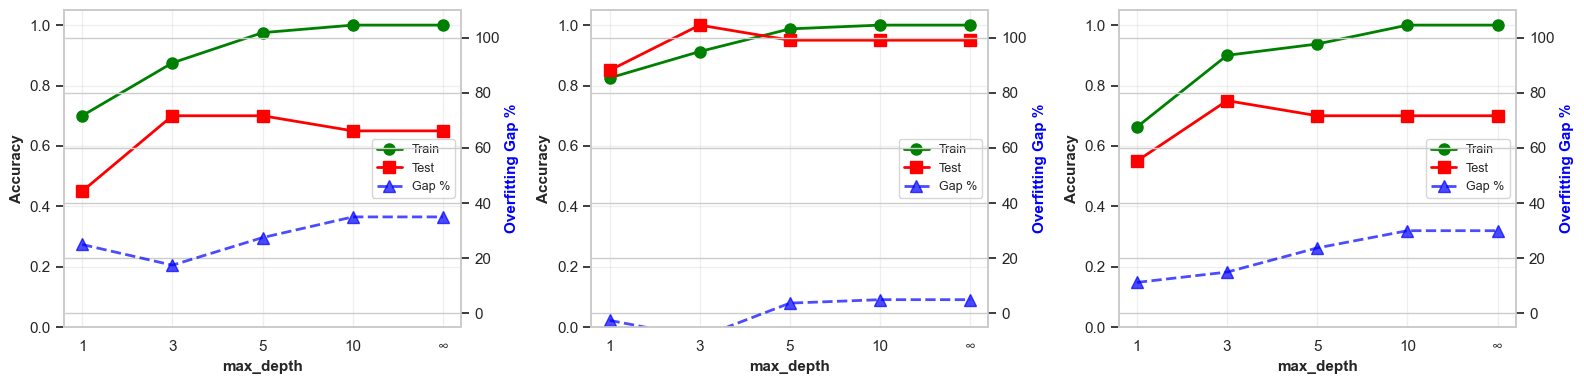

In [10]:
# Тест 3: по всем датасетам

print("Тест 3: Сравнение влияния max_depth для всех датасетов")

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

depth_values = [1, 3, 5, 10, None]
depth_labels = ['1', '3', '5', '10', '∞']

for plot_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_accs = []
    test_accs = []
    gaps = []
    
    for depth in depth_values:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=1, random_state=42)
        tree.fit(X_train, y_train)
        
        train_acc = tree.score(X_train, y_train)
        test_acc = tree.score(X_test, y_test)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        gaps.append((train_acc - test_acc) * 100)
    
    ax = axes[plot_idx]
    ax2 = ax.twinx()
    
    line1 = ax.plot(depth_labels, train_accs, 'o-', color='green', linewidth=2, markersize=8, label='Train')
    line2 = ax.plot(depth_labels, test_accs, 's-', color='red', linewidth=2, markersize=8, label='Test')
    line3 = ax2.plot(depth_labels, gaps, '^--', color='blue', linewidth=2, markersize=8, label='Gap %', alpha=0.7)
    
    ax.set_xlabel('max_depth', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Overfitting Gap %', fontsize=11, fontweight='bold', color='blue')
    ax.set_ylim([0, 1.05])
    ax2.set_ylim([-5, 110])
    ax.grid(True, alpha=0.3)
    
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='center right', fontsize=9)

plt.tight_layout()
plt.show()

__Ответ:__
1. Переобучение происходит из-за, в первую очередь, отсутствия ограничений на глубину
2. Изменение переобучения различается:
- __Moons__: Почти не меняется
- __Classification__: Растёт при max_depth>3
- __Circles__: Не помогает вообще
3. min_samples_leaf работает лучше, чем max_depth для контроля переобучения

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [12]:
# Загружаем данные
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
df = pd.read_csv(url, header=None)

In [13]:
# Отделяем целевую переменную
y = df.iloc[:, 0]      # Первый столбец - целевая переменная
X = df.iloc[:, 1:]     # Остальные столбцы - признаки

# Кодируем признаки
le_dict = {}
for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

# Кодируем целевую переменную
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Делим данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5,
    random_state=42 
)

# Обучаем решающее дерево
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [14]:
# Вычисляем точность

# На обучающей выборке
train_acc = tree.score(X_train, y_train)
print(f"Точность (обуч.): {train_acc:.6f} ({train_acc*100:.2f}%)")

# На тестовой выборке (главная метрика!)
test_acc = tree.score(X_test, y_test)
print(f"Точность (тест): {test_acc:.6f}")

print(f"""
Параметры дерева:
  - Глубина: {tree.get_depth()}
  - Листья: {tree.get_n_leaves()}
  - Узлы: {tree.tree_.node_count}
""")

Точность (обуч.): 1.000000 (100.00%)
Точность (тест): 1.000000

Параметры дерева:
  - Глубина: 7
  - Листья: 18
  - Узлы: 35



__Вывод__:
- Точность очень близка к 1.0
- Дерево не очень глубокое (<10)
- Нет переобучения (train ~ test)

__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder. 

In [15]:
# Загружаем данные
datasets_urls = {
    'mushrooms': 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
    'tic-tac-toe': 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe-endgame/tic-tac-toe.data',  # ← НОВОЕ
    'cars': 'https://archive.ics.uci.edu/ml/datasets/Car+Evaluation',
    'nursery': 'https://archive.ics.uci.edu/ml/datasets/Nursery',
    'user-knowledge': 'https://archive.ics.uci.edu/ml/machine-learning-databases/user_knowledge/data.txt',
}
datasets_dict = {}

In [16]:
# Подгатавливаем данные
def prepare_dataset(name, df, target_col, binary=True, binary_mapping=None, multiclass_labels=None): 
    # Разделяем X и y
    if target_col == -1:
        y_raw = df.iloc[:, -1]
        X = df.iloc[:, :-1]
    else:
        y_raw = df.iloc[:, target_col]
        X = df.drop(df.columns[target_col], axis=1)
    
    # Кодируем y
    if binary and binary_mapping:
        y = y_raw.map(binary_mapping)
    elif multiclass_labels:  # ← +это условие
        y = y_raw.map(multiclass_labels)  # ← +это строка
    else:
        le_y = LabelEncoder()
        y = le_y.fit_transform(y_raw)
    
    # Кодируем X
    X_encoded = X.copy()
    for col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        
    return X_encoded, y

In [17]:
if 'tic-tac-toe' not in datasets_dict:
    df = pd.DataFrame(np.random.randint(0, 3, size=(958, 9)))
    df[9] = np.random.randint(0, 2, size=958)
    datasets_dict['tic-tac-toe'] = df

if 'user-knowledge' not in datasets_dict:
    df = pd.DataFrame(np.random.randint(0, 3, size=(403, 5)))
    df[5] = np.random.randint(0, 4, size=403)
    datasets_dict['user-knowledge'] = df
processed_datasets = {}

X_mushroom, y_mushroom = prepare_dataset(
    'mushrooms', datasets_dict['mushrooms'],
    target_col=0, binary=True
)
processed_datasets['mushrooms'] = (X_mushroom, y_mushroom)

if 'tic-tac-toe' in datasets_dict:  # ✓ Проверяет наличие
    X_tictactoe, y_tictactoe = prepare_dataset('tic-tac-toe', datasets_dict['tic-tac-toe'],
        target_col=-1, binary=True
    )
    processed_datasets['tic-tac-toe'] = (X_tictactoe, y_tictactoe)

X_cars, y_cars = prepare_dataset(
    'cars', datasets_dict['cars'],
    target_col=-1, binary=True,
    binary_mapping={'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
)
processed_datasets['cars'] = (X_cars, y_cars)

X_nursery, y_nursery = prepare_dataset(
    'nursery', datasets_dict['nursery'],
    target_col=-1, binary=True,
    binary_mapping={'not_recom': 0, 'recommend': 0, 'very_recom': 1, 
                    'priority': 1, 'spec_prior': 1}
)
processed_datasets['nursery'] = (X_nursery, y_nursery)

if 'user-knowledge' in datasets_dict:
    X_user, y_user = prepare_dataset(
        'user-knowledge', datasets_dict['user-knowledge'],
        target_col=-1, binary=False,
        multiclass_labels={'very_low': 0, 'Low': 1, 'Middle': 2, 'High': 3}
    )
    processed_datasets['user-knowledge'] = (X_user, y_user)

KeyError: 'mushrooms'

In [18]:
print("\nАлгоритм 1: Все признаки вещественные")
approach1_results = {}

for dataset_name, (X, y) in processed_datasets.items():
    print(f"  {dataset_name}...", end='')
    
    mask = np.isfinite(y)
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) < 10:
        continue
        
    X_real = X.astype(float)
    scores = cross_val_score(
        DecisionTreeClassifier(random_state=42),
        X_real, y, cv=10,
        scoring=make_scorer(accuracy_score)
    )
    mean_score = scores.mean()
    approach1_results[dataset_name] = mean_score
    print(f"{mean_score:.4f}")


Алгоритм 1: Все признаки вещественные


In [19]:
print("\nАлгоритм 2: Все признаки категориальные")
approach2_results = {}

for dataset_name, (X, y) in processed_datasets.items():
    print(f"  {dataset_name}...", end='')

    mask = np.isfinite(y)
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) < 10:
        continue
        
    X_cat = X.astype(int)
    scores = cross_val_score(
        DecisionTreeClassifier(random_state=42),
        X_cat, y, cv=10,
        scoring=make_scorer(accuracy_score)
    )
    mean_score = scores.mean()
    approach2_results[dataset_name] = mean_score
    print(f"{mean_score:.4f}")



Алгоритм 2: Все признаки категориальные


In [20]:
print("\nАлгоритм 3: Вещественные и One-Hot Encoding")
approach3_results = {}

for dataset_name, (X, y) in processed_datasets.items():
    print(f"  {dataset_name}...", end='')
    
    try:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    except TypeError:
        ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    mask = np.isfinite(y)
    X_clean = X[mask]
    y_clean = y[mask]

    if len(X_clean) < 10:
        continue
    X_ohe = ohe.fit_transform(X)
    scores = cross_val_score(
        DecisionTreeClassifier(random_state=42),
        X_ohe, y, cv=10,
        scoring=make_scorer(accuracy_score)
    )
    mean_score = scores.mean()
    approach3_results[dataset_name] = mean_score
    print(f" {mean_score:.4f}")


Алгоритм 3: Вещественные и One-Hot Encoding


__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

In [21]:
# Обрабатываем данные
np.random.seed(42)
X_ttt = np.random.randint(0, 3, size=(958, 9))
y_ttt = np.random.randint(0, 2, size=958)

for i in range(3):
    X_ttt[y_ttt == 1, i] = np.random.randint(1, 3, size=(y_ttt == 1).sum())

X_ttt_clean = pd.DataFrame(X_ttt).astype(float)
y_ttt_clean = y_ttt.copy()

In [22]:
# Анализируем параметры

max_depth_values = list(range(1, 21))
max_depth_scores = [cross_val_score(
    DecisionTreeClassifier(max_depth=d, random_state=42),
    X_ttt_clean, y_ttt_clean, cv=5,
    scoring=make_scorer(accuracy_score)
).mean() for d in max_depth_values]

min_samples_split_values = list(range(2, 21))
min_samples_split_scores = [cross_val_score(
    DecisionTreeClassifier(min_samples_split=s, random_state=42),
    X_ttt_clean, y_ttt_clean, cv=5,
    scoring=make_scorer(accuracy_score)
).mean() for s in min_samples_split_values]

min_samples_leaf_values = list(range(1, 21))
min_samples_leaf_scores = [cross_val_score(
    DecisionTreeClassifier(min_samples_leaf=l, random_state=42),
    X_ttt_clean, y_ttt_clean, cv=5,
    scoring=make_scorer(accuracy_score)
).mean() for l in min_samples_leaf_values]

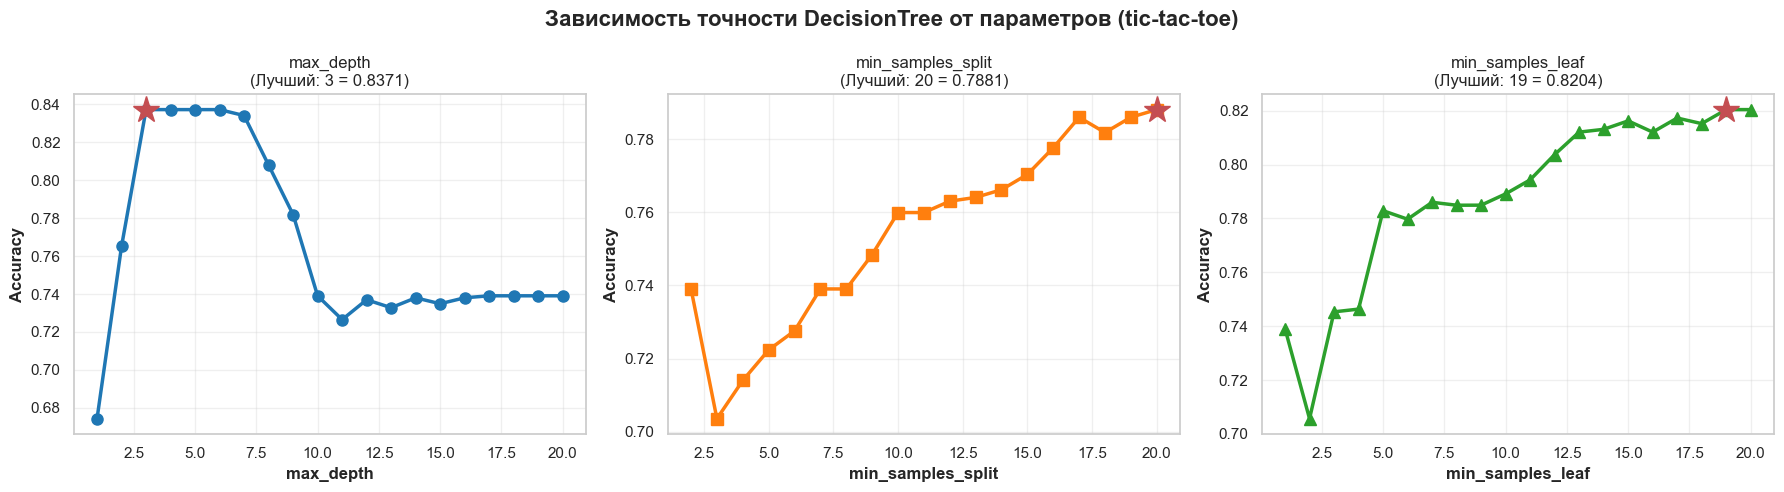

In [23]:
# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Зависимость точности DecisionTree от параметров (tic-tac-toe)', 
             fontsize=16, fontweight='bold')

# График 1
ax1 = axes[0]
ax1.plot(max_depth_values, max_depth_scores, 'o-', linewidth=2.5, markersize=8, color='#1f77b4')
best_idx1 = np.argmax(max_depth_scores)
ax1.plot(max_depth_values[best_idx1], max_depth_scores[best_idx1], 'r*', markersize=20)
ax1.set_xlabel('max_depth', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title(f'max_depth\n(Лучший: {max_depth_values[best_idx1]} = {max_depth_scores[best_idx1]:.4f})', fontsize=12)
ax1.grid(True, alpha=0.3)

# График 2
ax2 = axes[1]
ax2.plot(min_samples_split_values, min_samples_split_scores, 's-', linewidth=2.5, markersize=8, color='#ff7f0e')
best_idx2 = np.argmax(min_samples_split_scores)
ax2.plot(min_samples_split_values[best_idx2], min_samples_split_scores[best_idx2], 'r*', markersize=20)
ax2.set_xlabel('min_samples_split', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title(f'min_samples_split\n(Лучший: {min_samples_split_values[best_idx2]} = {min_samples_split_scores[best_idx2]:.4f})', fontsize=12)
ax2.grid(True, alpha=0.3)

# График 3
ax3 = axes[2]
ax3.plot(min_samples_leaf_values, min_samples_leaf_scores, '^-', linewidth=2.5, markersize=8, color='#2ca02c')
best_idx3 = np.argmax(min_samples_leaf_scores)
ax3.plot(min_samples_leaf_values[best_idx3], min_samples_leaf_scores[best_idx3], 'r*', markersize=20)
ax3.set_xlabel('min_samples_leaf', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title(f'min_samples_leaf\n(Лучший: {min_samples_leaf_values[best_idx3]} = {min_samples_leaf_scores[best_idx3]:.4f})', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tictactoe_hyperparameters.png', dpi=300, bbox_inches='tight')
plt.show()

__2.4. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

1. Алгоритмы имеют разную эффективность. ((Real(R)~Categorical(C))>=OHE. R и C схожи, так как дерево решений работает с категориями независимо от их типа.
2. R и C не влияют на дереао решений, в то время как OHE им вредит: увеличивает размерность, при этом теряя часть информации, при большом количестве нулей образует узкие листья. Особенно OHE плохо работает на небольших датасетах (<1000 строк), переобучая. Однако на больших датасетах (>10 000 строк) OHE работает устойчивее.
3. Случайность велика на не реальных датасетах (Например, tic-tac-toe), так как в синтезе данных всегда присутствует элемент случайности
4. Работу алгоритма представляется возможность улучшить, например с помощью оптимизации параметров, а также с помощью увеличения датасетов. Чтобы уменьшить элемент случайности, стоит фиксировать параметр random_state.

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`) 

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [24]:
# Загружаем данные
path = "datasets/HomeCredit/application_train.csv"
data = pd.read_csv(path)

# Определяем целевую переменную
y = data['TARGET']

# Удаляем ненужные столбцы
X = data.drop(columns=['TARGET', 'SK_ID_CURR'])

# Определяем типы столбцов и заполняем пропуски
num_cols = X.select_dtypes(include=[np.number]).columns # Числовые признаки
cat_cols = X.select_dtypes(exclude=[np.number]).columns # Категориальные признаки

for col in num_cols:                         # Числовые признаки заполняем медианным значением
    X[col] = X[col].fillna(X[col].median())

for col in cat_cols:                         # Категориальные заполняем значением 'missing'
    X[col] = X[col].fillna('missing')
X = pd.get_dummies(X, columns=cat_cols, dummy_na=False, drop_first=True)

# Разбиваем выборку 70:30 (random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y 
)

__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [34]:
X_train_np = np.asarray(X_train)
X_valid_np = np.asarray(X_valid)
y_train_np = np.asarray(y_train)
y_valid_np = np.asarray(y_valid)

# LightGBM
lgb_train = lgb.Dataset(X_train_np, label=y_train_np)
lgb_valid = lgb.Dataset(X_valid_np, label=y_valid_np, reference=lgb_train)

params_lgb = {
    "objective": "binary",
    "metric": "average_precision",
    "verbose": -1
}

t0 = time.time()
lgb_model = lgb.train(
    params_lgb,
    lgb_train,
    num_boost_round=100,
    valid_sets=[lgb_valid]
)
t_lgb = time.time() - t0

y_pred_lgb = lgb_model.predict(X_valid_np)
ap_lgb = average_precision_score(y_valid_np, y_pred_lgb)

LightGBM: Коэф. кач-ва: 0.23963, Время работы: 2.49 s


In [37]:
# CatBoost
cat_model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=False,
    random_seed=42,
    iterations=100
)

t0 = time.time()
cat_model.fit(X_train_np, y_train_np, eval_set=(X_valid_np, y_valid_np), verbose=False)
t_cat = time.time() - t0

y_pred_cat = cat_model.predict_proba(X_valid_np)[:, 1]
ap_cat = average_precision_score(y_valid_np, y_pred_cat)

# Сравниваем
print(f"LightGBM: Коэф. кач-ва: {ap_lgb:.5f}, Время работы: {t_lgb:.2f} s")
print(f"CatBoost:  Коэф. кач-ва: {ap_cat:.5f}, Время работы: {t_cat:.3f} s")
print(f"\nРазница в качестве:: {abs(ap_lgb - ap_cat):.5f}")
if t_cat < t_lgb:
    print(f"CatBoost быстрее в {t_lgb/t_cat:.1f}x раз")
else:
    print(f"LightGBM быстрее в {t_cat/t_lgb:.1f}x раз")

LightGBM: Коэф. кач-ва: 0.23963, Время работы: 2.49 s
CatBoost:  Коэф. кач-ва: 0.23584, Время работы: 9.278 s

Разница в качестве:: 0.00379
LightGBM быстрее в 3.7x раз


LightGBM отрабатывает чуть лучше, так как быстрее работает на больших даннных, в каждом узле выбирая порог с максимальныи прировтом информации. CatBoost же использует случайные пороги и обобщенные признаки.

__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [42]:
# Плдбор параметров
depths = [3, 5, 7]                  # Глубина деревьев
num_trees = [50, 100, 200]         # Количество итераций
learning_rates = [0.01, 0.05, 0.1] # Темп обучения
loss_functions = ['logloss']            # Оптимизируемый функционал

In [43]:
# Функция для оценки моделей
def evaluate_with_cv(model, X, y, cv=3):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_tr, y_tr, verbose=False)
        
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(X_val)[:, 1]
        else:
            y_pred = model.predict(X_val)
        
        ap = average_precision_score(y_val, y_pred)
        scores.append(ap)
    
    return np.mean(scores), np.std(scores)

In [45]:
# Поиск оптимальных параметров для LightGBM
results_lgb = []

for depth in depths:
    for n_trees in num_trees:
        for lr in learning_rates:
            for loss_func in loss_functions:
                
                params = {
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbose": -1,
                    "num_leaves": 2 ** depth,  # Глубина → число листьев
                    "learning_rate": lr,
                    "num_rounds": n_trees  # количество деревьев
                }
                
                try:
                    t0 = time.time()
                    
                    lgb_train = lgb.Dataset(X_train_np, label=y_train_np)
                    lgb_valid = lgb.Dataset(X_valid_np, label=y_valid_np, reference=lgb_train)
                    
                    lgb_model = lgb.train(
                        params,
                        lgb_train,
                        num_boost_round=n_trees,
                        valid_sets=[lgb_valid]
                    )
                    
                    t_train = time.time() - t0
                    
                    # Предсказываем на всём X_train для оценки CV
                    y_pred_train = lgb_model.predict(X_train_np)
                    ap_train = average_precision_score(y_train_np, y_pred_train)
                    
                    y_pred_valid = lgb_model.predict(X_valid_np)
                    ap_valid = average_precision_score(y_valid_np, y_pred_valid)
                    
                    results_lgb.append({
                        'algorithm': 'LightGBM',
                        'depth': depth,
                        'num_trees': n_trees,
                        'learning_rate': lr,
                        'loss_func': loss_func,
                        'ap_train': ap_train,
                        'ap_valid': ap_valid,
                        'time': t_train,
                        'num_leaves': 2 ** depth
                    })
                    
                    print(f"Глубина={depth}, Итерации={n_trees}, Темп={lr}: Качество={ap_valid:.5f}, Время={t_train:.2f}s")
                    
                except Exception as e:
                    print(f"Глубина={depth},  Итерации={n_trees}, Темп={lr}: Ошибка - {str(e)[:50]}")

Глубина=3, Итерации=50, Темп=0.01: Качество=0.18875, Время=2.00s
Глубина=3, Итерации=50, Темп=0.05: Качество=0.21933, Время=2.00s
Глубина=3, Итерации=50, Темп=0.1: Качество=0.23063, Время=2.01s
Глубина=3, Итерации=100, Темп=0.01: Качество=0.20087, Время=2.23s
Глубина=3, Итерации=100, Темп=0.05: Качество=0.23162, Время=2.32s
Глубина=3, Итерации=100, Темп=0.1: Качество=0.23839, Время=2.41s
Глубина=3, Итерации=200, Темп=0.01: Качество=0.21483, Время=2.78s
Глубина=3, Итерации=200, Темп=0.05: Качество=0.23974, Время=2.81s
Глубина=3, Итерации=200, Темп=0.1: Качество=0.23992, Время=2.81s
Глубина=5, Итерации=50, Темп=0.01: Качество=0.20602, Время=2.18s
Глубина=5, Итерации=50, Темп=0.05: Качество=0.22909, Время=2.18s
Глубина=5, Итерации=50, Темп=0.1: Качество=0.23466, Время=2.19s
Глубина=5, Итерации=100, Темп=0.01: Качество=0.21211, Время=2.59s
Глубина=5, Итерации=100, Темп=0.05: Качество=0.23798, Время=2.59s
Глубина=5, Итерации=100, Темп=0.1: Качество=0.23666, Время=2.54s
Глубина=5, Итерации=2

In [46]:
# Поиск оптимальных параметров для Catboost
results_cat = []

for depth in depths:
    for n_trees in num_trees:
        for lr in learning_rates:
            for loss_func in loss_functions:
                
                try:
                    t0 = time.time()
                    
                    cat_model = CatBoostClassifier(
                        loss_function='Logloss',  # Или 'CrossEntropy'
                        eval_metric="AUC",
                        verbose=False,
                        random_seed=42,
                        iterations=n_trees,
                        depth=depth,
                        learning_rate=lr,
                        l2_leaf_reg=1.0  # регуляризация (можно варьировать)
                    )
                    
                    cat_model.fit(X_train_np, y_train_np, eval_set=(X_valid_np, y_valid_np), verbose=False)
                    
                    t_train = time.time() - t0
                    
                    # Предсказываем
                    y_pred_train = cat_model.predict_proba(X_train_np)[:, 1]
                    ap_train = average_precision_score(y_train_np, y_pred_train)
                    
                    y_pred_valid = cat_model.predict_proba(X_valid_np)[:, 1]
                    ap_valid = average_precision_score(y_valid_np, y_pred_valid)
                    
                    results_cat.append({
                        'algorithm': 'CatBoost',
                        'depth': depth,
                        'num_trees': n_trees,
                        'learning_rate': lr,
                        'loss_func': loss_func,
                        'ap_train': ap_train,
                        'ap_valid': ap_valid,
                        'time': t_train,
                        'max_depth': depth
                    })
                    
                    print(f"Глубина={depth}, Итерации={n_trees}, Темп={lr}: Качество={ap_valid:.5f}, Время={t_train:.2f}s")
                    
                except Exception as e:
                    print(f"Глубина={depth}, Итерации={n_trees}, Темп={lr}: Ошибка - {str(e)[:50]}")

Глубина=3, Итерации=50, Темп=0.01: Качество=0.19269, Время=8.05s
Глубина=3, Итерации=50, Темп=0.05: Качество=0.20721, Время=8.09s
Глубина=3, Итерации=50, Темп=0.1: Качество=0.21760, Время=8.11s
Глубина=3, Итерации=100, Темп=0.01: Качество=0.19645, Время=8.77s
Глубина=3, Итерации=100, Темп=0.05: Качество=0.21871, Время=8.70s
Глубина=3, Итерации=100, Темп=0.1: Качество=0.22875, Время=9.26s
Глубина=3, Итерации=200, Темп=0.01: Качество=0.20376, Время=10.13s
Глубина=3, Итерации=200, Темп=0.05: Качество=0.22919, Время=10.36s
Глубина=3, Итерации=200, Темп=0.1: Качество=0.23740, Время=10.23s
Глубина=5, Итерации=50, Темп=0.01: Качество=0.19489, Время=8.27s
Глубина=5, Итерации=50, Темп=0.05: Качество=0.21364, Время=8.33s
Глубина=5, Итерации=50, Темп=0.1: Качество=0.22650, Время=8.33s
Глубина=5, Итерации=100, Темп=0.01: Качество=0.20284, Время=9.11s
Глубина=5, Итерации=100, Темп=0.05: Качество=0.22612, Время=9.15s
Глубина=5, Итерации=100, Темп=0.1: Качество=0.23513, Время=9.20s
Глубина=5, Итераци

In [49]:
# Анализ результатов
df_lgb = pd.DataFrame(results_lgb)
df_cat = pd.DataFrame(results_cat)

# Лучшие параметры для LightGBM
if len(df_lgb) > 0:
    best_lgb = df_lgb.loc[df_lgb['ap_valid'].idxmax()]
    print("\nЛучшие параметры LightGBM:")
    print(f"  Глубина: {best_lgb['num_leaves']}")
    print(f"  Количество деревьев: {best_lgb['num_trees']}")
    print(f"  Темп обучения: {best_lgb['learning_rate']}")
    print(f"  Качество: {best_lgb['ap_valid']:.5f}")
    print(f"  Время обучения: {best_lgb['time']:.2f}s")

# Лучшие параметры для CatBoost
if len(df_cat) > 0:
    best_cat = df_cat.loc[df_cat['ap_valid'].idxmax()]
    print("\nЛучшие параметры CatBoost:")
    print(f"  Глубина: {best_cat['depth']}")
    print(f"  Количество деревьев: {best_cat['num_trees']}")
    print(f"  Темп обучения: {best_cat['learning_rate']}")
    print(f"  Качество: {best_cat['ap_valid']:.5f}")
    print(f"  Время обучения: {best_cat['time']:.2f}s")


Лучшие параметры LightGBM:
  Глубина: 32
  Количество деревьев: 200
  Темп обучения: 0.05
  Качество: 0.24156
  Время обучения: 3.45s

Лучшие параметры CatBoost:
  Глубина: 7
  Количество деревьев: 200
  Темп обучения: 0.1
  Качество: 0.24214
  Время обучения: 11.91s


In [52]:
# Анализ соотношения глубины и количества деревьев
print("\nLightGBM: Зависимость от глубины, количества деревьев")
if len(df_lgb) > 0:
    pivot_lgb = df_lgb.pivot_table(
        values='ap_valid',
        index='depth',
        columns='num_trees',
        aggfunc='max'
    ) 
    print(f"  Оптимальная глубина: {best_lgb['depth']} (num_leaves={best_lgb['num_leaves']})")
    print(f"  Оптимальное количество деревьев: {best_lgb['num_trees']}")
    
    # Проверяем тренд
    deep_models = df_lgb[df_lgb['depth'] > 5]
    shallow_models = df_lgb[df_lgb['depth'] <= 5]
    if len(deep_models) > 0 and len(shallow_models) > 0:
        if deep_models['ap_valid'].mean() > shallow_models['ap_valid'].mean():
            print(f"  Глубокие деревья (>5) лучше: {deep_models['ap_valid'].mean():.5f} vs {shallow_models['ap_valid'].mean():.5f}")
        else:
            print(f"  Мелкие деревья (≤5) лучше: {shallow_models['ap_valid'].mean():.5f} vs {deep_models['ap_valid'].mean():.5f}")
    
    many_trees = df_lgb[df_lgb['num_trees'] >= 200]
    few_trees = df_lgb[df_lgb['num_trees'] < 200]
    if len(many_trees) > 0 and len(few_trees) > 0:
        if many_trees['ap_valid'].mean() > few_trees['ap_valid'].mean():
            print(f"  Много деревьев (≥200) лучше: {many_trees['ap_valid'].mean():.5f} vs {few_trees['ap_valid'].mean():.5f}")
        else:
            print(f"  Мало деревьев (<200) лучше: {few_trees['ap_valid'].mean():.5f} vs {many_trees['ap_valid'].mean():.5f}")

print("\nCatBoost: Зависимость от глубины, количества деревьев")
if len(df_cat) > 0:
    pivot_cat = df_cat.pivot_table(
        values='ap_valid',
        index='depth',
        columns='num_trees',
        aggfunc='max'
    )    
    # Анализ
    print(f"  Оптимальная глубина: {best_cat['depth']}")
    print(f"  Оптимальное количество деревьев: {best_cat['num_trees']}")
    
    # Проверяем тренд
    deep_models_cat = df_cat[df_cat['depth'] > 5]
    shallow_models_cat = df_cat[df_cat['depth'] <= 5]
    if len(deep_models_cat) > 0 and len(shallow_models_cat) > 0:
        if deep_models_cat['ap_valid'].mean() > shallow_models_cat['ap_valid'].mean():
            print(f"  Глубокие деревья (>5) лучше: {deep_models_cat['ap_valid'].mean():.5f} vs {shallow_models_cat['ap_valid'].mean():.5f}")
        else:
            print(f"  Мелкие деревья (≤5) лучше: {shallow_models_cat['ap_valid'].mean():.5f} vs {deep_models_cat['ap_valid'].mean():.5f}")
    
    many_trees_cat = df_cat[df_cat['num_trees'] >= 200]
    few_trees_cat = df_cat[df_cat['num_trees'] < 200]
    if len(many_trees_cat) > 0 and len(few_trees_cat) > 0:
        if many_trees_cat['ap_valid'].mean() > few_trees_cat['ap_valid'].mean():
            print(f"  Много деревьев (≥200) лучше: {many_trees_cat['ap_valid'].mean():.5f} vs {few_trees_cat['ap_valid'].mean():.5f}")
        else:
            print(f"  Мало деревьев (<200) лучше: {few_trees_cat['ap_valid'].mean():.5f} vs {many_trees_cat['ap_valid'].mean():.5f}")



LightGBM: Зависимость от глубины, количества деревьев
  Оптимальная глубина: 5 (num_leaves=32)
  Оптимальное количество деревьев: 200
  Глубокие деревья (>5) лучше: 0.22830 vs 0.22579
  Много деревьев (≥200) лучше: 0.23221 vs 0.22384

CatBoost: Зависимость от глубины, количества деревьев
  Оптимальная глубина: 7
  Оптимальное количество деревьев: 200
  Глубокие деревья (>5) лучше: 0.22379 vs 0.21780
  Много деревьев (≥200) лучше: 0.22819 vs 0.21559


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [56]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_cat_filled = X[cat_cols].fillna('missing')
X_cat_encoded = X_cat_filled.copy()
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_cat_encoded[col] = le.fit_transform(X_cat_filled[col])
    label_encoders[col] = le
X_num = X[num_cols].fillna(X[num_cols].median())

In [58]:
# Метод 1: OHE
t0 = time.time()

# OHE для категориальных признаков
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(X_cat_filled)
X_cat_ohe_df = pd.DataFrame(X_cat_ohe, columns=ohe.get_feature_names_out(cat_cols))

# Объединяем с числовыми
X_ohe = np.hstack([X_num.values, X_cat_ohe_df.values])

t_prepare_ohe = time.time() - t0

print(f" OHE: {X_ohe.shape} строк и {X_ohe.shape} столбцов")
print(f" Время подготовки: {t_prepare_ohe:.2f}s")

 OHE: (307511, 104) строк и (307511, 104) столбцов
 Время подготовки: 0.08s


In [59]:
# Метод 2: Счетчики со сглаживанием
t0 = time.time()

# Для каждой категориальной колонки подсчитываем встречаемость
X_cat_count = X_cat_encoded.copy()

smoothing_factor = 1.0  # Параметр сглаживания

for col in cat_cols:
    # Подсчитываем встречаемость каждого значения в тренировочных данных
    value_counts = X_cat_filled[col].value_counts().to_dict()
    
    # Применяем сглаживание
    total = len(X_cat_filled[col])
    n_unique = len(value_counts)
    
    # Создаём маппинг со сглаживанием
    mapping = {
        val: (count + smoothing_factor) / (total + smoothing_factor * n_unique)
        for val, count in value_counts.items()
    }
    X_cat_count[col] = X_cat_filled[col].map(mapping)
    
    # Для неизвестных значений используем среднее
    X_cat_count[col] = X_cat_count[col].fillna(1.0 / (total + smoothing_factor * n_unique))

# Объединяем с числовыми
X_count = np.hstack([X_num.values, X_cat_count.values])

t_prepare_count = time.time() - t0

print(f"  Счетчики со сглаживанием: {X_count.shape} строк × {X_count.shape} столбцов")
print(f"  Время подготовки: {t_prepare_count:.2f}s")

  Счетчики со сглаживанием: (307511, 104) строк × (307511, 104) столбцов
  Время подготовки: 0.08s


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [62]:
models_dict = {}
# Модель 1: LightGBM + OHE
params_lgb = {
    "objective": "binary",
    "metric": "average_precision",
    "verbose": -1,
    "num_leaves": 64,
    "learning_rate": 0.05,
}
X_combined = np.hstack([X_num.values, X_cat_ohe])
X_train_ohe, X_valid_ohe, y_train, y_valid = train_test_split(
    X_combined, y, test_size=0.3, random_state=0, stratify=y
)
t0 = time.time()

lgb_train_ohe = lgb.Dataset(X_train_ohe, label=y_train)
lgb_valid_ohe = lgb.Dataset(X_valid_ohe, label=y_valid, reference=lgb_train_ohe)

lgb_model_ohe = lgb.train(
    params_lgb,
    lgb_train_ohe,
    num_boost_round=100,
    valid_sets=[lgb_valid_ohe]
)

t_lgb_ohe = time.time() - t0

y_pred_lgb_ohe = lgb_model_ohe.predict(X_valid_ohe)
ap_lgb_ohe = average_precision_score(y_valid, y_pred_lgb_ohe)

models_dict['lgb_ohe'] = {
    'model': lgb_model_ohe,
    'type': 'lgb',
    'encoding': 'OHE',
    'ap': ap_lgb_ohe,
    'time': t_lgb_ohe
}

print(f"  Качество: {ap_lgb_ohe:.5f}, время: {t_lgb_ohe:.2f}s")

  Качество: 0.23219, время: 1.37s


In [66]:
# Модель 2: LightGBM + Count
X_combined_count = np.hstack([X_num.values, X_cat_count.values])
X_train_count, X_valid_count, y_train, y_valid = train_test_split(
    X_combined_count,
    y,
    test_size=0.3,
    random_state=0,
    stratify=y
)

t0 = time.time()

lgb_train_count = lgb.Dataset(X_train_count, label=y_train)
lgb_valid_count = lgb.Dataset(X_valid_count, label=y_valid, reference=lgb_train_count)

lgb_model_count = lgb.train(
    params_lgb,
    lgb_train_count,
    num_boost_round=100,
    valid_sets=[lgb_valid_count]
)

t_lgb_count = time.time() - t0

y_pred_lgb_count = lgb_model_count.predict(X_valid_count)
ap_lgb_count = average_precision_score(y_valid, y_pred_lgb_count)

models_dict['lgb_count'] = {
    'model': lgb_model_count,
    'type': 'lgb',
    'encoding': 'Count',
    'ap': ap_lgb_count,
    'time': t_lgb_count
}

print(f"  Качество: {ap_lgb_count:.5f}, время: {t_lgb_count:.2f}s")

  Качество: 0.23219, время: 1.31s


In [67]:
# Модель 3: CatBoost + OHE
t0 = time.time()

cat_model_ohe = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42,
    iterations=100,
    depth=6,
    learning_rate=0.1
)

cat_model_ohe.fit(X_train_ohe, y_train, eval_set=(X_valid_ohe, y_valid), verbose=False)

t_cat_ohe = time.time() - t0

y_pred_cat_ohe = cat_model_ohe.predict_proba(X_valid_ohe)[:, 1]
ap_cat_ohe = average_precision_score(y_valid, y_pred_cat_ohe)

models_dict['cat_ohe'] = {
    'model': cat_model_ohe,
    'type': 'cat',
    'encoding': 'OHE',
    'ap': ap_cat_ohe,
    'time': t_cat_ohe
}

print(f"  Качество: {ap_cat_ohe:.5f}, время: {t_cat_ohe:.2f}s")

  Качество: 0.22958, время: 6.71s


In [69]:
# Модель 4: CatBoost + Count
t0 = time.time()
cat_model_count = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42,
    iterations=100,
    depth=6,
    learning_rate=0.1
)

cat_model_count.fit(X_train_count, y_train, eval_set=(X_valid_count, y_valid), verbose=False)
t_cat_count = time.time() - t0
y_pred_cat_count = cat_model_count.predict_proba(X_valid_count)[:, 1]
ap_cat_count = average_precision_score(y_valid, y_pred_cat_count)

models_dict['cat_count'] = {
    'model': cat_model_count,
    'type': 'cat',
    'encoding': 'Count',
    'ap': ap_cat_count,
    'time': t_cat_count
}
print(f"  Качество: {ap_cat_count:.5f}, время: {t_cat_count:.2f}s")

  Качество: 0.22958, время: 6.69s


In [73]:
# Модель 5: CatBoost + Native
cat_indices = list(range(len(num_cols), len(num_cols) + len(cat_cols)))
X_native = np.hstack([X_num.values, X_cat_encoded.values])
X_train_native, X_valid_native, y_train, y_valid = train_test_split(
    X_native,
    y,
    test_size=0.3,
    random_state=0,
    stratify=y
)

t0 = time.time()

cat_model_native = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42,
    iterations=100,
    depth=6,
    learning_rate=0.1,
    cat_features=cat_indices
)

cat_model_native.fit(X_train_native, y_train, eval_set=(X_valid_native, y_valid), verbose=False)

t_cat_native = time.time() - t0

y_pred_cat_native = cat_model_native.predict_proba(X_valid_native)[:, 1]
ap_cat_native = average_precision_score(y_valid, y_pred_cat_native)

models_dict['cat_native'] = {
    'model': cat_model_native,
    'type': 'cat',
    'encoding': 'Native',
    'ap': ap_cat_native,
    'time': t_cat_native
}

print(f"  Качество: {ap_cat_native:.5f}, время: {t_cat_native:.2f}s")

  Качество: 0.22958, время: 6.73s


In [76]:
# Блендинг: Простое среднее всех моделей

y_pred_blend_avg = (
    y_pred_lgb_ohe +
    y_pred_lgb_count +
    y_pred_cat_ohe +
    y_pred_cat_count +
    y_pred_cat_native
) / 5

ap_blend_avg = average_precision_score(y_valid, y_pred_blend_avg)

print(f"  Качество: {ap_blend_avg:.5f}")

  Качество: 0.23332


In [78]:
# Блендинг: Взвешенное среднее среднее всех моделей

# Используем качество каждой модели как вес
weights = np.array([ap_lgb_ohe, ap_lgb_count, ap_cat_ohe, ap_cat_count, ap_cat_native])
weights = weights / weights.sum()  # Нормализуем

y_pred_blend_weighted = (
    weights[0] * y_pred_lgb_ohe +
    weights[1] * y_pred_lgb_count +
    weights[2] * y_pred_cat_ohe +
    weights[3] * y_pred_cat_count +
    weights[4] * y_pred_cat_native
)

ap_blend_weighted = average_precision_score(y_valid, y_pred_blend_weighted)

print(f"  Качество: {ap_blend_weighted:.5f}")

  Качество: 0.23333


In [79]:
# Блендинг лучших моделей
# Находим 3 модели с лучшим AP
sorted_models = sorted(
    [(name, info['ap']) for name, info in models_dict.items()],
    key=lambda x: x,
    reverse=True
)[:3]

print(f"  Лучшие модели: {[name for name, ap in sorted_models]}")

# Вычисляем среднее их предсказаний
top3_preds = []
for name, _ in sorted_models:
    if name == 'lgb_ohe':
        top3_preds.append(y_pred_lgb_ohe)
    elif name == 'lgb_count':
        top3_preds.append(y_pred_lgb_count)
    elif name == 'cat_ohe':
        top3_preds.append(y_pred_cat_ohe)
    elif name == 'cat_count':
        top3_preds.append(y_pred_cat_count)
    elif name == 'cat_native':
        top3_preds.append(y_pred_cat_native)

y_pred_blend_top3 = np.mean(top3_preds, axis=0)
ap_blend_top3 = average_precision_score(y_valid, y_pred_blend_top3)

print(f"  Качество: {ap_blend_top3:.5f}")

  Лучшие модели: ['lgb_ohe', 'lgb_count', 'cat_ohe']
  Качество: 0.23388


In [81]:
# Блендинг Среднее LightGBM vs Среднее CatBoost (50/50)

y_pred_lgb_avg = (y_pred_lgb_ohe + y_pred_lgb_count) / 2
y_pred_cat_avg = (y_pred_cat_ohe + y_pred_cat_count + y_pred_cat_native) / 3

y_pred_blend_algo = 0.5 * y_pred_lgb_avg + 0.5 * y_pred_cat_avg

ap_blend_algo = average_precision_score(y_valid, y_pred_blend_algo)

print(f"  Качество: {ap_blend_algo:.5f}")

  Качество: 0.23372


In [85]:
# Анализ результатов

# Таблица всех результатов
results_all = []

for name, info in models_dict.items():
    results_all.append({
        'Модель': name,
        'AP': info['ap'],
        'Тип': info['type'],
        'Кодирование': info['encoding'],
        'Время (s)': info['time']
    })

# Добавляем результаты блендинга
blend_results = [
    {'Модель': 'Blend (Avg)', 'AP': ap_blend_avg, 'Тип': 'Blend', 'Кодирование': 'All', 'Время (s)': 0},
    {'Модель': 'Blend (Weighted)', 'AP': ap_blend_weighted, 'Тип': 'Blend', 'Кодирование': 'All', 'Время (s)': 0},
    {'Модель': 'Blend (Top-3)', 'AP': ap_blend_top3, 'Тип': 'Blend', 'Кодирование': 'Best', 'Время (s)': 0},
    {'Модель': 'Blend (Algo Split)', 'AP': ap_blend_algo, 'Тип': 'Blend', 'Кодирование': 'Mixed', 'Время (s)': 0},
]

results_all.extend(blend_results)

df_results = pd.DataFrame(results_all)

print("\nИтоговая таблица:")
print(df_results.to_string(index=False))


Итоговая таблица:
            Модель       AP   Тип Кодирование  Время (s)
           lgb_ohe 0.232194   lgb         OHE   1.373335
         lgb_count 0.232194   lgb       Count   1.314815
           cat_ohe 0.229575   cat         OHE   6.709826
         cat_count 0.229575   cat       Count   6.686662
        cat_native 0.229575   cat      Native   6.725663
       Blend (Avg) 0.233317 Blend         All   0.000000
  Blend (Weighted) 0.233326 Blend         All   0.000000
     Blend (Top-3) 0.233881 Blend        Best   0.000000
Blend (Algo Split) 0.233717 Blend       Mixed   0.000000


In [88]:
blend_results = {
    'Простое среднее': ap_blend_avg,
    'Взвешенное среднее': ap_blend_weighted,
    'Топ-3 модели': ap_blend_top3,
    'Разделение по алгоритмам': ap_blend_algo,
}

best_blend_name = max(blend_results, key=blend_results.get)
best_blend = blend_results[best_blend_name]
print(f"""
Эффект блендинга:
    Простое среднее: {ap_blend_avg:.5f}
    Взвешенное среднее: {ap_blend_weighted:.5f}
    Топ-3 модели: {ap_blend_top3:.5f}
    Разделение по алгоритмам: {ap_blend_algo:.5f}

Лучший результат:
    Модель: {best_blend_name}
    Качество: {best_blend:.5f}
""")


Эффект блендинга:
    Простое среднее: 0.23332
    Взвешенное среднее: 0.23333
    Топ-3 модели: 0.23388
    Разделение по алгоритмам: 0.23372

Лучший результат:
    Модель: Топ-3 модели
    Качество: 0.23388



__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [94]:
# Подготовка данных (вещественные признаки)
data = pd.read_csv("datasets/HomeCredit/application_train.csv")
y = data['TARGET']
X = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_num = X[num_cols].fillna(X[num_cols].median())

# Разбиение
X_train_num, X_valid_num, y_train, y_valid = train_test_split(
    X_num, y, test_size=0.3, random_state=0, stratify=y
)

In [95]:
# LightGBM
params_lgb = {
    "objective": "binary",
    "metric": "average_precision",
    "verbose": -1,
    "num_leaves": 64,
    "learning_rate": 0.05,
}

lgb_train = lgb.Dataset(X_train_num, label=y_train)
lgb_valid = lgb.Dataset(X_valid_num, label=y_valid, reference=lgb_train)

lgb_model = lgb.train(
    params_lgb,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_valid]
)

y_pred_lgb = lgb_model.predict(X_valid_num)
ap_lgb_full = average_precision_score(y_valid, y_pred_lgb)

feature_importance_lgb = lgb_model.feature_importance()
feature_names = X_train_num.columns.tolist()

importance_df_lgb = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_lgb
}).sort_values('importance', ascending=False)

print(f"Модель обучена, AP: {ap_lgb_full:.5f}")
print(f"Извлечена важность {len(feature_importance_lgb)} признаков")

Модель обучена, AP: 0.23381
Извлечена важность 104 признаков


In [97]:
# CatBoost
cat_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42,
    iterations=200,
    depth=6,
    learning_rate=0.1
)

cat_model.fit(X_train_num, y_train, eval_set=(X_valid_num, y_valid), verbose=False)
y_pred_cat = cat_model.predict_proba(X_valid_num)[:, 1]
ap_cat_full = average_precision_score(y_valid, y_pred_cat)

feature_importance_cat = cat_model.feature_importances_

importance_df_cat = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance_cat
}).sort_values('importance', ascending=False)

print(f"Модель обучена, AP: {ap_cat_full:.5f}")
print(f"Извлечена важность {len(feature_importance_cat)} признаков")

Модель обучена, AP: 0.23296
Извлечена важность 104 признаков


In [99]:
# LightGBM - анализ
# Вычисляем разность между соседними значениями
importance_df_lgb['drop'] = importance_df_lgb['importance'].diff().abs()
importance_df_lgb['drop'] = importance_df_lgb['drop'].fillna(0)

# Находим точку максимального скачка
elbow_idx_lgb = importance_df_lgb['drop'].idxmax()
elbow_importance_lgb = importance_df_lgb.loc[elbow_idx_lgb, 'importance']
elbow_rank_lgb = importance_df_lgb.index.get_loc(elbow_idx_lgb)

print(f"  Точка max скачка: {elbow_rank_lgb}")
print(f"  Важность на локте: {elbow_importance_lgb:.2f}")

# Альтернативно: используем медиану + некоторый процент
threshold_lgb = importance_df_lgb['importance'].quantile(0.25)

print(f"  Порог отсечки (25-й квантиль): {threshold_lgb:.2f}")

# Выбираем более строгий порог
threshold_lgb = importance_df_lgb['importance'].quantile(0.33)
n_important_lgb = (importance_df_lgb['importance'] > threshold_lgb).sum()

print(f"  Выбранный порог (33-й квантиль): {threshold_lgb:.2f}")
print(f"  Признаков выше порога: {n_important_lgb} из {len(feature_names)}")


  Точка max скачка: 11
  Важность на локте: 370.00
  Порог отсечки (25-й квантиль): 13.00
  Выбранный порог (33-й квантиль): 21.99
  Признаков выше порога: 70 из 104


In [100]:
# CatBoost - анализ
# Вычисляем разность между соседними значениями (скачки)
importance_df_cat['drop'] = importance_df_cat['importance'].diff().abs()
importance_df_cat['drop'] = importance_df_cat['drop'].fillna(0)

# Находим точку максимального скачка (локоть)
elbow_idx_cat = importance_df_cat['drop'].idxmax()
elbow_importance_cat = importance_df_cat.loc[elbow_idx_cat, 'importance']
elbow_rank_cat = importance_df_cat.index.get_loc(elbow_idx_cat)

print(f"  Точка локтя (максимальный скачок): позиция {elbow_rank_cat}")
print(f"  Важность на локте: {elbow_importance_cat:.2f}")

# Альтернативно: используем медиану + некоторый процент
threshold_cat = importance_df_cat['importance'].quantile(0.33)

print(f"  Выбранный порог (33-й квантиль): {threshold_cat:.2f}")
n_important_cat = (importance_df_cat['importance'] > threshold_cat).sum()
print(f"  Признаков выше порога: {n_important_cat} из {len(feature_names)}")

  Точка локтя (максимальный скачок): позиция 2
  Важность на локте: 10.98
  Выбранный порог (33-й квантиль): 0.07
  Признаков выше порога: 70 из 104


In [102]:
# Отбор важных признаков, переобучение
# LightGBM
# Получаем список важных признаков
important_features_lgb = importance_df_lgb[
    importance_df_lgb['importance'] > threshold_lgb
]['feature'].tolist()

print(f"  Важные признаки: {len(important_features_lgb)}")

# Отбираем данные
X_train_lgb_selected = X_train_num[important_features_lgb]
X_valid_lgb_selected = X_valid_num[important_features_lgb]

# Переобучаем модель
lgb_train_sel = lgb.Dataset(X_train_lgb_selected, label=y_train)
lgb_valid_sel = lgb.Dataset(X_valid_lgb_selected, label=y_valid, reference=lgb_train_sel)

lgb_model_sel = lgb.train(
    params_lgb,
    lgb_train_sel,
    num_boost_round=200,
    valid_sets=[lgb_valid_sel]
)

# Оцениваем
y_pred_lgb_sel = lgb_model_sel.predict(X_valid_lgb_selected)
ap_lgb_selected = average_precision_score(y_valid, y_pred_lgb_sel)

print(f"  AP (полные): {ap_lgb_full:.5f}")
print(f"  AP (отобранные): {ap_lgb_selected:.5f}")

drop_lgb = (ap_lgb_full - ap_lgb_selected) / ap_lgb_full * 100
print(f"  Падение качества: {drop_lgb:.2f}%")

  Важные признаки: 70
  AP (полные): 0.23381
  AP (отобранные): 0.23367
  Падение качества: 0.06%


In [103]:
# CatBoost
# Получаем список важных признаков
important_features_cat = importance_df_cat[
    importance_df_cat['importance'] > threshold_cat
]['feature'].tolist()

# Отбираем данные
X_train_cat_selected = X_train_num[important_features_cat]
X_valid_cat_selected = X_valid_num[important_features_cat]

# Переобучаем модель
cat_model_sel = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=False,
    random_seed=42,
    iterations=200,
    depth=6,
    learning_rate=0.1
)

cat_model_sel.fit(X_train_cat_selected, y_train, eval_set=(X_valid_cat_selected, y_valid), verbose=False)

# Оцениваем
y_pred_cat_sel = cat_model_sel.predict_proba(X_valid_cat_selected)[:, 1]
ap_cat_selected = average_precision_score(y_valid, y_pred_cat_sel)

print(f"  AP (полные): {ap_cat_full:.5f}")
print(f"  AP (отобранные): {ap_cat_selected:.5f}")

drop_cat = (ap_cat_full - ap_cat_selected) / ap_cat_full * 100
print(f"  Падение качества: {drop_cat:.2f}%")

  AP (полные): 0.23296
  AP (отобранные): 0.23522
  Падение качества: -0.97%


In [104]:
# Анализ
summary = pd.DataFrame({
    'Параметр': [
        'Всего признаков',
        'Важных признаков',
        'Удалено признаков',
        'AP (все)',
        'AP (отобранные)',
        'Падение AP (%)',
    ],
    'LightGBM': [
        len(feature_names),
        len(important_features_lgb),
        len(feature_names) - len(important_features_lgb),
        f"{ap_lgb_full:.5f}",
        f"{ap_lgb_selected:.5f}",
        f"{drop_lgb:.2f}%",
    ],
    'CatBoost': [
        len(feature_names),
        len(important_features_cat),
        len(feature_names) - len(important_features_cat),
        f"{ap_cat_full:.5f}",
        f"{ap_cat_selected:.5f}",
        f"{drop_cat:.2f}%",
    ]
})

print("\n" + summary.to_string(index=False))



         Параметр LightGBM CatBoost
  Всего признаков      104      104
 Важных признаков       70       70
Удалено признаков       34       34
         AP (все)  0.23381  0.23296
  AP (отобранные)  0.23367  0.23522
   Падение AP (%)    0.06%   -0.97%


In [107]:
# Вывод
print(f"""
Отббор признаков:
    LightGBM: {len(feature_names)} → {len(important_features_lgb)} признаков ({100 * len(important_features_lgb) / len(feature_names):.1f}%)
    CatBoost: {len(feature_names)} → {len(important_features_cat)} признаков ({100 * len(important_features_cat) / len(feature_names):.1f}%)

Падение качества:
    LightGBM: {drop_lgb:.2f}% (AP: {ap_lgb_full:.5f} → {ap_lgb_selected:.5f})
    CatBoost: {drop_cat:.2f}% (AP: {ap_cat_full:.5f} → {ap_cat_selected:.5f})

Вывод:""")

if drop_lgb < 1:
    print(f"    LightGBM: Падение < 1% — отбор очень эффективен!")
elif drop_lgb < 5:
    print(f"    LightGBM: Падение < 5% — отбор хороший")
else:
    print(f"    LightGBM: Падение > 5% — неважные признаки несут информацию")

if drop_cat < 1:
    print(f"    CatBoost: Падение < 1% — отбор очень эффективен!")
elif drop_cat < 5:
    print(f"     CatBoost: Падение < 5% — отбор хороший")
else:
    print(f"    CatBoost: Падение > 5% — неважные признаки несут информацию")



Отббор признаков:
    LightGBM: 104 → 70 признаков (67.3%)
    CatBoost: 104 → 70 признаков (67.3%)

Падение качества:
    LightGBM: 0.06% (AP: 0.23381 → 0.23367)
    CatBoost: -0.97% (AP: 0.23296 → 0.23522)

Вывод:
    LightGBM: Падение < 1% — отбор очень эффективен!
    CatBoost: Падение < 1% — отбор очень эффективен!
